<a href="https://colab.research.google.com/github/tema7707/My-little-Kaggle-projects/blob/master/Chinese_character_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Chinese character recognition

Download dataset from Kaggle

https://www.kaggle.com/c/chinese-char-recognition-smmo19

In [0]:
!pip install -q kaggle/
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list

In [0]:
!kaggle competitions download -c chinese-char-recognition-smmo19
!unzip train-1.npy.zip -d characters
!unzip train-2.npy.zip -d characters
!unzip train-3.npy.zip -d characters
!unzip train-4.npy.zip -d characters
!unzip test.npy.zip -d characters

Import packages and visualize data

In [0]:
!pip install numpy==1.16.1
import numpy as np
import random
import cv2
import os
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

(83246, 2)
(83247, 2)
(83247, 2)
(83247, 2)


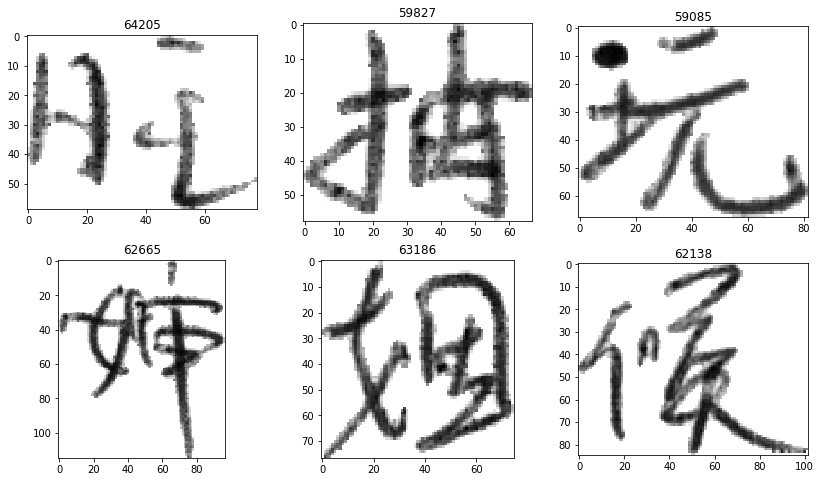

In [2]:
def show():
  fig = plt.figure(figsize=(14, 8))
  i = 1
  for sample in random.choices(data, k=6):
    fig.add_subplot(2, 3, i)
    plt.imshow(sample[0], cmap='gray')
    plt.title(sample[1])
    i += 1
  plt.show()

# load train_set
if not os.path.exists("/content/imgs/"):
  os.makedirs("/content/imgs/")
for train_num in range(1,5):
  data = np.load("characters/train-{}.npy".format(train_num))
  X_train = data[:,0]
  y_train = data[:,1]
  for i in np.unique(y_train):
    directory = "/content/imgs/{}".format(i)
    if not os.path.exists(directory):
      os.makedirs(directory)

  for i in range(len(data)):
    cv2.imwrite('/content/imgs/{}/{}.png'.format(y_train[i],i+90000*2000), X_train[i])

show()

### I want to learn ensemble of 10 CNN. 

For this action I need a lot of images. So let's do augmentation  and some normalization. I resize each image to a size of 28x28. 

In [3]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = [None] * 10
training_set = [None] * 10
test_set = [None] * 10
for i in range(10):
  train_datagen[i] = ImageDataGenerator(
      rescale = 1./255,
      zoom_range = 0.1,
      height_shift_range = 0.1,
      width_shift_range = 0.1,
      rotation_range = 10,
      validation_split=0.2)

  training_set[i] = train_datagen[i].flow_from_directory(
      '/content/imgs/',
      target_size=(28,28),
      batch_size=32,
      color_mode='grayscale',
      subset='training'
    )
  test_set[i] = train_datagen[i].flow_from_directory(
      '/content/imgs/',
      target_size=(28,28),
      batch_size=32,
      color_mode='grayscale',
      subset='validation'
    )

  # Check img
  batch = training_set[i].next()
  cv2_imshow(batch[0][25] * 255)
  batch[0][25].shape

Using TensorFlow backend.


Found 266389 images belonging to 1000 classes.
Found 66095 images belonging to 1000 classes.


Found 266389 images belonging to 1000 classes.
Found 66095 images belonging to 1000 classes.


Found 266389 images belonging to 1000 classes.
Found 66095 images belonging to 1000 classes.


Found 266389 images belonging to 1000 classes.
Found 66095 images belonging to 1000 classes.


Found 266389 images belonging to 1000 classes.
Found 66095 images belonging to 1000 classes.


Found 266389 images belonging to 1000 classes.
Found 66095 images belonging to 1000 classes.


Found 266389 images belonging to 1000 classes.
Found 66095 images belonging to 1000 classes.


Found 266389 images belonging to 1000 classes.
Found 66095 images belonging to 1000 classes.


Found 266389 images belonging to 1000 classes.
Found 66095 images belonging to 1000 classes.


Found 266389 images belonging to 1000 classes.
Found 66095 images belonging to 1000 classes.


In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Activation
from keras.layers import Convolution2D, Conv2D
from keras.layers import MaxPooling2D, MaxPool2D
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization

# Init CNN
classifier = [None] * 10
for i in range(10):
  classifier[i] = Sequential()

  classifier[i].add(Conv2D(32, kernel_size = 3, activation='relu', input_shape = (28, 28, 1)))
  classifier[i].add(BatchNormalization())
  classifier[i].add(Conv2D(32, kernel_size = 3, activation='relu'))
  classifier[i].add(BatchNormalization())
  classifier[i].add(Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
  classifier[i].add(BatchNormalization())
  classifier[i].add(Dropout(0.4))

  classifier[i].add(Conv2D(64, kernel_size = 3, activation='relu'))
  classifier[i].add(BatchNormalization())
  classifier[i].add(Conv2D(64, kernel_size = 3, activation='relu'))
  classifier[i].add(BatchNormalization())
  classifier[i].add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
  classifier[i].add(BatchNormalization())
  classifier[i].add(Dropout(0.4))

  classifier[i].add(Conv2D(128, kernel_size = 4, activation='relu'))
  classifier[i].add(BatchNormalization())
  classifier[i].add(Flatten())
  classifier[i].add(Dropout(0.4))
  classifier[i].add(Dense(1000, activation='softmax'))

  classifier[i].compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Because train process of 10 CNNs is long process I will save weights to my Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
from IPython import display
from PIL import Image
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)
for i in range(0,10):
  checkpoint_path = "/content/drive/My Drive/cp{}.ckpt".format(i)
  # Callback that will save weights
  cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                                save_weights_only=True,
                                verbose=1)
  if os.path.exists(checkpoint_path):
    classifier[i].load_weights(checkpoint_path)

  classifier[i].fit_generator(
      training_set[i],
      steps_per_epoch=240000//32,
      epochs=20,
      validation_data=test_set[i],
      validation_steps=300,
      callbacks=[cp_callback, annealer]
  )

Download test data

In [8]:
if not os.path.exists("/content/test/"):
  os.makedirs("/content/test/")
data = np.load("characters/test.npy")

for i in range(len(data)):
  cv2.imwrite('/content/test/{}.png'.format(i), data[i])

(83247,)


In [0]:
length = data.shape[0]
del data

Create dictionary of the labels

In [0]:
data = np.load("characters/train-1.npy")
y_train = data[:,1]
dictionary = {}
j = 0
for i in np.unique(y_train):
    dictionary[j] = i 
    j = j + 1

del data

Make predictions by combining each CNN's predictions.
Save results to csv file.

In [0]:
f = open('predictions.csv','w')
f.write("Id,Category\n")

for i in range(length):
  img = cv2.imread('/content/test/{}.png'.format(i), cv2.IMREAD_GRAYSCALE)
  img = cv2.resize(img /255, (28, 28), interpolation = cv2.INTER_AREA)
  img = np.expand_dims(img, axis=2)
  img = np.expand_dims(img, axis=0)
  ans = classifier[0].predict(img)
  for j in range(1, 10):
    ans = ans + classifier[j].predict(img)
  f.write((str(i+1) + "," + str(dictionary[ans.argmax()]))+'\n')
  del img

f.close()